# Load the data

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
data_dir = Path("data")

X_test = data_dir / "X_test.csv"
y_train = data_dir / "y_train.csv"
X_train = data_dir / "X_train.csv"

X_test = pd.read_csv(X_test, index_col="id")
X_test.index = X_test.index.astype(int)

y_train = pd.read_csv(y_train, index_col="id")
y_train.index = y_train.index.astype(int)

X_train = pd.read_csv(X_train, index_col="id")
X_train.index = X_train.index.astype(int)

print(f"X_train.shape {X_train.shape}, y_train.shape {y_train.shape}, X_test.shape {X_test.shape}")

print(X_train.head())

X_train.shape (1212, 832), y_train.shape (1212, 1), X_test.shape (776, 832)
              x0            x1           x2             x3          x4  \
id                                                                       
0   14168.823171  10514.380717  3316.149698   94230.695124  102.386606   
1   17757.037554           NaN  4101.016273   92959.527633         NaN   
2   14226.656663  11029.642499          NaN  124055.600561  100.542483   
3    8766.012436   7384.202998  2147.308418  100157.719990  104.855061   
4   13801.016418  13269.493652  3408.316953   92048.527786  103.759758   

            x5            x6            x7            x8         x9  ...  \
id                                                                   ...   
0    92.677127  11108.748199  10866.505510  10837.622093  10.227734  ...   
1    99.855168  10013.959449  10826.607494  10076.101597  11.436970  ...   
2    92.860892           NaN  10492.342868           NaN  10.810076  ...   
3   101.929026  10050.049

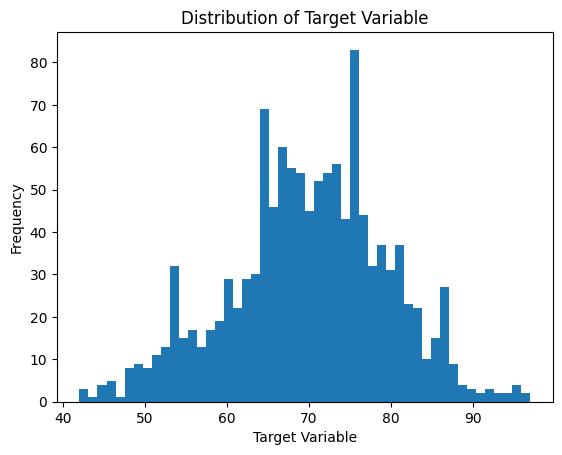

In [3]:
#have a look at the data
import matplotlib.pyplot as plt
plt.hist(y_train.values, bins=50)
plt.xlabel("Target Variable")
plt.ylabel("Frequency")
plt.title("Distribution of Target Variable")
plt.show()


# 1. imputing missing values

First we impute nan values with the mean for each feature

In [4]:
X_train.fillna(pd.Series(X_train.mean()), inplace=True)
print(f"Nan-values: {X_train.isna().sum().sum()}")
print(X_train.head())
X_test.fillna(pd.Series(X_test.mean()), inplace=True)
y_train.fillna(pd.Series(y_train.mean()), inplace=True)

Nan-values: 0
              x0            x1           x2             x3          x4  \
id                                                                       
0   14168.823171  10514.380717  3316.149698   94230.695124  102.386606   
1   17757.037554  10950.160761  4101.016273   92959.527633  105.070358   
2   14226.656663  11029.642499  3430.837498  124055.600561  100.542483   
3    8766.012436   7384.202998  2147.308418  100157.719990  104.855061   
4   13801.016418  13269.493652  3408.316953   92048.527786  103.759758   

            x5            x6            x7            x8         x9  ...  \
id                                                                   ...   
0    92.677127  11108.748199  10866.505510  10837.622093  10.227734  ...   
1    99.855168  10013.959449  10826.607494  10076.101597  11.436970  ...   
2    92.860892   9983.055476  10492.342868  10495.835570  10.810076  ...   
3   101.929026  10050.049932  10499.521099  10525.030989  10.092109  ...   
4    95.789

# 2. Outlier detection
Next we build an outlier detection model to classify samples as outliers and eventually remove them

In [5]:
#outlier detection using isolation forest and guessing the contamination to be 5%

from sklearn.ensemble import IsolationForest
outlier_model = IsolationForest(contamination=0.05, random_state=42)
outlier_model.fit(X_train)
outlier_preds = outlier_model.predict(X_train)
isoforest_outlier_indices = set(np.where(outlier_preds == -1)[0])

print("Outlier indices:", isoforest_outlier_indices)

print(f"Number of outliers detected: {len(isoforest_outlier_indices)}")

Outlier indices: {np.int64(3), np.int64(515), np.int64(645), np.int64(900), np.int64(1031), np.int64(648), np.int64(906), np.int64(397), np.int64(917), np.int64(278), np.int64(24), np.int64(1048), np.int64(30), np.int64(416), np.int64(1056), np.int64(1058), np.int64(805), np.int64(167), np.int64(297), np.int64(681), np.int64(428), np.int64(306), np.int64(821), np.int64(694), np.int64(697), np.int64(953), np.int64(573), np.int64(190), np.int64(575), np.int64(64), np.int64(321), np.int64(448), np.int64(837), np.int64(70), np.int64(583), np.int64(75), np.int64(460), np.int64(972), np.int64(1102), np.int64(335), np.int64(474), np.int64(91), np.int64(731), np.int64(860), np.int64(991), np.int64(480), np.int64(225), np.int64(1120), np.int64(100), np.int64(229), np.int64(740), np.int64(231), np.int64(234), np.int64(362), np.int64(1137), np.int64(114), np.int64(882), np.int64(502), np.int64(1144), np.int64(506), np.int64(1150)}
Number of outliers detected: 61


In [6]:
# outlier detection using OneClassSVM

from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler



scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

svm_model = OneClassSVM(nu=0.01, kernel="rbf", gamma="scale")
svm_model.fit(X_train_scaled)
svm_preds = svm_model.predict(X_train_scaled)

print("SVM Outlier indices:", np.where(svm_preds == -1)[0])

svm_outlier_indices = set(np.where(svm_preds == -1)[0])

print(f"Number of outliers detected by SVM: {np.sum(svm_preds == -1)}")

# Comparing the two methods
common_outliers = isoforest_outlier_indices & svm_outlier_indices
print(f"Number of common outliers detected by both methods: {len(common_outliers)}")
print("Common outlier indices:", common_outliers)

SVM Outlier indices: [  16   30   32   56   70   72   88   91  142  168  180  207  211  214
  245  278  313  321  334  352  397  403  404  431  518  537  545  553
  570  574  583  616  622  631  633  635  681  694  731  732  741  755
  771  805  806  808  836  872  882  888  899  900  906  917  949  953
  972  990  994 1001 1038 1066 1081 1087 1102 1132 1135 1144 1205]
Number of outliers detected by SVM: 69
Number of common outliers detected by both methods: 19
Common outlier indices: {np.int64(900), np.int64(906), np.int64(397), np.int64(917), np.int64(278), np.int64(30), np.int64(805), np.int64(681), np.int64(694), np.int64(953), np.int64(321), np.int64(70), np.int64(583), np.int64(972), np.int64(1102), np.int64(731), np.int64(91), np.int64(882), np.int64(1144)}


In [7]:
#removing outliers from the training data
X_train_cleaned = X_train.drop(index=X_train.index[list(common_outliers)])
y_train_cleaned = y_train.drop(index=y_train.index[list(common_outliers)])
print(f"Cleaned X_train shape: {X_train_cleaned.shape}, Cleaned y_train shape: {y_train_cleaned.shape}")

Cleaned X_train shape: (1193, 832), Cleaned y_train shape: (1193, 1)


# Feature selection

this step is harder than imagined, a new idea came to my mind:

1: select a subset of features randomly, train and score the predictions, as well as the features used

2: do it for another subset

3: mark the features which occur in higher scored subsets and use these for the final training (Monte Carlo aproach)

In [8]:

def correlation_matrix_reduction(df, threshold=0.9):
    """
    Remove highly correlated features (one from each pair).
    
    Parameters:
    df (pd.DataFrame): Input feature DataFrame
    threshold (float): Correlation threshold
    
    Returns:
    list: Features to drop
    """
    # Compute absolute correlation matrix
    corr_matrix = df.corr().abs()
    
    # Create upper triangle mask
    mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    upper = corr_matrix.where(mask)
    
    # Find columns with any correlation > threshold in upper triangle
    to_drop = [col for col in upper.columns if (upper[col] > threshold).any()]
    
    print("Highly correlated features to drop:", to_drop)
    print(f"Number of features to drop: {len(to_drop)}")
    
    return to_drop


to_drop_corr = correlation_matrix_reduction(X_train_cleaned, threshold=0.9)

Highly correlated features to drop: ['x69', 'x132', 'x151', 'x202', 'x230', 'x231', 'x240', 'x250', 'x278', 'x288', 'x316', 'x317', 'x333', 'x334', 'x348', 'x374', 'x392', 'x414', 'x442', 'x479', 'x502', 'x505', 'x562', 'x568', 'x579', 'x610', 'x614', 'x634', 'x668', 'x675', 'x698', 'x715', 'x727', 'x774', 'x780', 'x790']
Number of features to drop: 36


In [9]:
#remove low variance features
from sklearn.feature_selection import VarianceThreshold
def low_variance_reduction(threshold=0.01):
    selector = VarianceThreshold(threshold=threshold)
    selector.fit(X_train_cleaned)
    to_keep = X_train_cleaned.columns[selector.get_support()]
    to_drop = [col for col in X_train_cleaned.columns if col not in to_keep]
    print("Low variance features to drop:", to_drop)
    print(f"Number of low variance features to drop: {len(to_drop)}")
    return to_drop
to_drop_var = low_variance_reduction()

final_to_drop = list(set(to_drop_corr) | set(to_drop_var))
print("Final features to drop:", final_to_drop)
X_selected = X_train_cleaned.drop(columns=final_to_drop, inplace=False)

print(f"Shape after feature reduction: {X_selected.shape}")


Low variance features to drop: ['x33', 'x67', 'x68', 'x104', 'x129', 'x147', 'x166', 'x179', 'x183', 'x185', 'x189', 'x195', 'x196', 'x207', 'x208', 'x229', 'x262', 'x271', 'x281', 'x289', 'x292', 'x295', 'x296', 'x305', 'x307', 'x336', 'x338', 'x363', 'x384', 'x385', 'x446', 'x450', 'x462', 'x466', 'x489', 'x492', 'x500', 'x519', 'x529', 'x530', 'x550', 'x556', 'x580', 'x583', 'x586', 'x593', 'x605', 'x620', 'x625', 'x628', 'x666', 'x679', 'x682', 'x709', 'x724', 'x755', 'x803', 'x808', 'x815']
Number of low variance features to drop: 59
Final features to drop: ['x492', 'x292', 'x815', 'x519', 'x129', 'x727', 'x202', 'x338', 'x281', 'x450', 'x414', 'x675', 'x147', 'x374', 'x336', 'x334', 'x195', 'x724', 'x67', 'x668', 'x392', 'x132', 'x586', 'x278', 'x208', 'x803', 'x625', 'x183', 'x295', 'x610', 'x185', 'x207', 'x666', 'x580', 'x289', 'x620', 'x262', 'x774', 'x530', 'x384', 'x305', 'x529', 'x166', 'x348', 'x316', 'x240', 'x151', 'x715', 'x780', 'x271', 'x296', 'x568', 'x579', 'x250',

# Main Task, fit a model

we will go ahead and try the polynomial regression using the kernel trick


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error

X_train, X_val, y_train, y_val = train_test_split(
    X_selected, y_train_cleaned, test_size=0.1, random_state=42
) 

model = {
    "KernelRidge": {
        "model": KernelRidge(kernel="rbf"),
        "params": {
            "model__alpha": [1e-3, 1e-6, 1e-9, 1e-12],
            #"model__degree": [2, 3, 4, 5, 6, 10, 20]
            "model__gamma": [5e-5, 1e-5, 5e-6, 1e-6, 5e-7], 
        }
    }
}
results = []
for model_name, mp in model.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', mp["model"])
    ])
    
    grid = GridSearchCV(pipeline, mp["params"], cv=5, scoring='r2', n_jobs=-1)
    grid.fit(X_train, y_train)
    
    print(f"Best parameters for {model_name}: {grid.best_params_}")
    
    y_val_pred = grid.predict(X_val)
    y_train_pred = grid.predict(X_train)
    val_r2 = r2_score(y_val, y_val_pred)
    print(f"Validation R2 score for {model_name}: {val_r2}")

    # Metrics
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_val, y_val_pred)
    test_mae = mean_absolute_error(y_val, y_val_pred)

    results.append({
        "Model": model_name,
        "Best R² (CV)": grid.best_score_,
        "Train R²": train_r2,
        "Test R²": test_r2,
        "Test MAE": test_mae,
        "Best Params": grid.best_params_
    })

    print(f"→ {model_name} | CV R²: {grid.best_score_:.4f} | Test R²: {test_r2:.4f} | Test MAE: {test_mae:.4f}")


Best parameters for KernelRidge: {'model__alpha': 0.001, 'model__gamma': 5e-07}
Validation R2 score for KernelRidge: 0.30056321741496783
→ KernelRidge | CV R²: 0.3029 | Test R²: 0.3006 | Test MAE: 6.2537


Baseline (Ridge) CV RMSE: 19.123255909766982
Fitting 5 folds for each of 56 candidates, totalling 280 fits
KRR best params: {'krr__alpha': 1, 'krr__gamma': np.float64(0.0001)}
KRR best CV RMSE: 8.053083868135246
CV RMSE: 8.0349 ± 0.5410; CV R2: 0.3097 ± 0.0331
Fitting 5 folds for each of 30 candidates, totalling 150 fits
SVR best params: {'svr__gamma': np.float64(0.002682695795279727), 'svr__epsilon': 0.001, 'svr__C': np.float64(1000.0)}
SVR best CV RMSE: 7.908582775518763
CV RMSE: 7.8881 ± 0.5693; CV R2: 0.3349 ± 0.0366

-- Kernel approximation with Nystroem --
Nystroem best params: {'nystroem__n_components': 500, 'nystroem__gamma': np.float64(0.0001)}
CV RMSE: nan ± nan; CV R2: nan ± nan


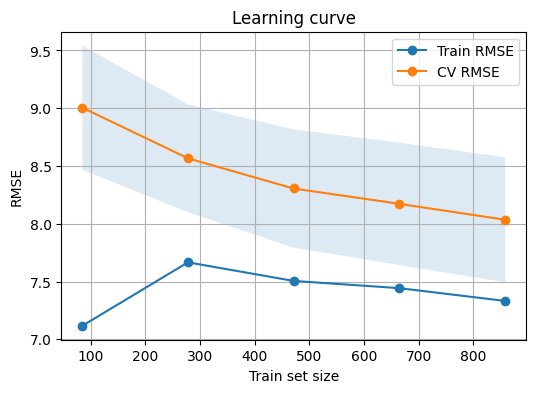

In [25]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, learning_curve
from sklearn.kernel_approximation import Nystroem, RBFSampler
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Prepare data
X = X_train.values if hasattr(X_train, "values") else np.array(X_train)
y = y_train.values.ravel() if hasattr(y_train, "values") else np.array(y_train).ravel()

# Baseline: simple linear model to see if kernel is necessary
from sklearn.linear_model import Ridge
baseline = Pipeline([("scaler", StandardScaler()), ("ridge", Ridge(alpha=1.0))])
cv = 5
print("Baseline (Ridge) CV RMSE:", np.sqrt(-cross_val_score(baseline, X, y, scoring="neg_mean_squared_error", cv=cv)).mean())

# Utility to evaluate a model with CV and final fit
def evaluate_model(model, X, y, cv=5):
    negmse = cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=cv)
    r2 = cross_val_score(model, X, y, scoring="r2", cv=cv)
    print(f"CV RMSE: {np.sqrt(-negmse).mean():.4f} ± {np.sqrt(-negmse).std():.4f}; CV R2: {r2.mean():.4f} ± {r2.std():.4f}")


# 3) If n is large, approximate RBF with Nystroem
print("\n-- Kernel approximation with Nystroem --")
pipe_nys = Pipeline([
    ("scaler", StandardScaler()),
    ("nystroem", Nystroem(kernel="rbf")),
])

param_grid_nys = {
    "nystroem__gamma": np.logspace(-4, 1, 6),
    "nystroem__n_components": [500, 800, 1000],
}

search_nys = RandomizedSearchCV(pipe_nys, param_grid_nys, n_iter=24, scoring="neg_mean_squared_error", cv=5, n_jobs=-1, random_state=0)
search_nys.fit(X, y)
print("Nystroem best params:", search_nys.best_params_)
evaluate_model(search_nys.best_estimator_, X, y)



# Train the model once again on the full dataset for the public test

# Save the test results for online evaluation

In [ ]:
from datetime import datetime

results_dir = Path("results")
results_dir.mkdir(exist_ok=True)


def save_test_predictions(model, model_name)-> Path:
    model = final_training(model)
    save_path = results_dir / f"test_{model_name}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"

    y_test_pred = model.predict(X_test[X_selected.columns])
    results_df = pd.DataFrame(y_test_pred, index=X_test.index, columns=["y"])
    assert (results_df.shape == (776, 1)), f"Unexpected shape: {results_df.shape}"
    results_df.to_csv(save_path)
    print(f"Test predictions saved to {save_path}")
    return save_path


file = save_test_predictions(XGBRegressor, "xgboost")



'kaggle competitions submit -c eth-aml-2025-project-1 -f submission.csv -m "Message"'

{'model__subsample': 0.6, 'model__reg_alpha': 0.6, 'model__n_estimators': 600, 'model__max_depth': 9, 'model__learning_rate': 0.02, 'model__gamma': 1, 'model__colsample_bytree': 0.7}


/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [10:38:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "model__colsample_bytree", "model__gamma", "model__learning_rate", "model__max_depth", "model__n_estimators", "model__reg_alpha", "model__subsample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Test predictions saved to results/test_xgboost_20251104_103859.csv


'kaggle competitions submit -c eth-aml-2025-project-1 -f submission.csv -m "Message"'

In [ ]:
import subprocess

#submit predictions
def submit_predictions(file:Path, message:str) -> None:
    cmd = f'kaggle competitions submit -c eth-aml-2025-project-1 -f {file} -m "{message}"'
    res = subprocess.run(cmd, shell=True, check=True)
    print(res.stdout, res.stderr)

submit_msg = input("Enter submission message: ")
submit_predictions(file, submit_msg)

100%|██████████| 9.93k/9.93k [00:00<00:00, 25.4kB/s]


Successfully submitted to ETH AML 2025 Project 1None None
